In [1]:
import torch
import os
import torch.nn.functional as F
from torch import Tensor
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm, trange

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

def sbs(strings, size=30, space=4):
    strings = list(strings)
    result = []

    while any(strings):
        line = []

        for i, s in enumerate(strings):
            if s is None:
                s = ""
            buf = s[:size]
            
            try:
                n = buf.index("\n")
                line.append(buf[:n].ljust(size))
                strings[i] = s[n+1:]
            except ValueError:
                line.append(buf.ljust(size))
                strings[i] = s[size:]

        result.append((" " * space).join(line))
    
    return "\n".join(result)

# device = "cuda:4"

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

device_ids = [3]
model = nn.DataParallel(model, device_ids=device_ids)
n_gpu = len(device_ids)

model.to(f"cuda:{device_ids[0]}")
model.device_ids


max_length = 512
def tokenize(texts):
    tensors = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors="pt")
    return {k : v for k, v in tensors.items()}

def embed(texts):
    with torch.no_grad():
        t = tokenize(texts)
        
        last_state = model(**t).last_hidden_state
        return last_token_pool(last_state, t["attention_mask"])

def embed_batched(texts, bs=512):
    n = len(texts)
    res = []
    for i in trange(0, n, bs):
        res.append(embed(texts[i:i+bs]))
    return list(torch.cat(res).cpu().numpy().squeeze())

KeyboardInterrupt: 

In [2]:
path = "../../data/"
data = pd.read_csv(path + 'train_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')

In [3]:
video['text'] = video.apply(lambda x: x['title'] + f' Категория: {x['category']}', axis=1)
video['duration_sec'] = video['duration'] // 1000
targets['sex'] = targets['sex'].apply(lambda x: 0 if x == 'male' else 1)

In [4]:
merged_data = data.merge(video, on='rutube_video_id', how='inner')
merged_data['count'] = merged_data.groupby('viewer_uid')['viewer_uid'].transform('count')
#merged_data[(merged_data['count'] > 10) & (merged_data['count'] < 20)]['viewer_uid']

In [10]:
embeds = embed_batched(list(video['title']))

100%|██████████| 3762/3762 [17:39<00:00,  3.55it/s]


In [34]:
#np.save('data/embeds.npy', embeds)
embeds = np.load('data/embeds.npy')

In [35]:
from sklearn.decomposition import PCA

def reduce_dimensionality(data, target_dimension=32):
    """
    Уменьшает размерность данных с d до target_dimension с помощью PCA.

    Args:
        data (numpy.ndarray): Исходные данные размерности (n_samples, d).
        target_dimension (int): Желаемая размерность выходных данных. По умолчанию 32.

    Returns:
        numpy.ndarray: Данные размерности (n_samples, target_dimension).
    """
    # Инициализируем PCA с целевой размерностью
    pca = PCA(n_components=target_dimension)
    
    # Применяем PCA к данным
    reduced_data = pca.fit_transform(data)
    
    return reduced_data

embeds_32 = reduce_dimensionality(embeds, target_dimension=256)

In [10]:
#np.save('data/embeds_32.npy', embeds_32)
embeds_32 = np.load('data/embeds_32.npy')

In [5]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pymystem3
tqdm.pandas()

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
stemmer = pymystem3.Mystem()


def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление ненужных символов
    text = re.sub(r'[^a-zа-яё0-9\s]', '', text)
    text = ''.join(stemmer.lemmatize(text))
    return text


merged_data['cleaned_text'] = merged_data['text'].progress_apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/kuzakov-
[nltk_data]     dn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1759616/1759616 [07:25<00:00, 3947.14it/s]


In [11]:
# Создание tf-idf векторов
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, min_df=0.001, max_df=0.1)
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_data['cleaned_text'])

In [12]:
merged_data['tf_idf_embeds'] = np.array(tfidf_matrix)

In [13]:
tfidf_vectorizer.get_feature_names_out()

array(['01062024', '02062024', '03062024', '04062024', '05062024',
       '06062024', '10', '100', '10062024', '11', '11062024', '12', '13',
       '13062024', '14', '14062024', '15', '16', '17', '17062024', '18',
       '18062024', '19', '19062024', '1999', '20', '2001', '2002', '2003',
       '2004', '2005', '2006', '20062024', '2007', '20072019', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
       '21', '21062024', '22', '23', '24', '24062024', '25', '25062024',
       '26', '26062024', '27', '27062024', '28', '28052024', '28062024',
       '29', '29052024', '30', '30052024', '31052024', '333', '41', '45',
       '56', '57', '58', '59', '911', 'and', 'bad', 'bang', 'better',
       'big', 'bones', 'boys', 'break', 'breaking', 'bridgerton', 'call',
       'castle', 'classrooms', 'club', 'comedy', 'dark', 'de', 'diaries',
       'doctor', 'fallout', 'files', 'friends', 'good', 'jas

In [14]:
targets.head()

,viewer_uid,age,sex,age_class
0,10087154,30,0,1
1,10908708,25,1,1
2,10190464,34,0,2
3,10939673,25,0,1
4,10288257,48,0,3


In [15]:
data.head()

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976


In [16]:
data = data.sort_values(by='event_timestamp')

In [17]:
video.head()

,rutube_video_id,title,category,duration,author_id,text,duration_sec
0,video_185549,Как собрать букет из мыльных тюльпанов - Силик...,Хобби,1559160,1015054,Как собрать букет из мыльных тюльпанов - Силик...,1559
1,video_111035,"Осторожно, Киберземляне!, 1 сезон, 12 серия",Сериалы,1320007,1002180,"Осторожно, Киберземляне!, 1 сезон, 12 серия Ка...",1320
2,video_476517,ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...,Хобби,606145,1095337,ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...,606
3,video_157198,"Хороший лжец (фильм, 2019)",Фильмы,6577440,1043618,"Хороший лжец (фильм, 2019) Категория: Фильмы",6577
4,video_289824,Нашего старого гнобят по-всякому,Развлечения,859493,1009535,Нашего старого гнобят по-всякому Категория: Ра...,859


In [64]:
X = np.stack(video['embeds'])
y = video['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# CatBoost для предсказания пола
catboost_cat = CatBoostClassifier(iterations=1000, verbose=150, task_type="GPU", devices='3')
catboost_cat.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_gender = catboost_cat.predict(X_test)

print("Classification report for gender prediction:")
print(classification_report(y_test, y_pred_gender))

Learning rate set to 0.186365
0:	learn: 2.5413746	test: 2.5440332	best: 2.5440332 (0)	total: 45.5ms	remaining: 45.5s
150:	learn: 1.2579594	test: 1.3729223	best: 1.3729223 (150)	total: 6.78s	remaining: 38.1s
300:	learn: 1.0873548	test: 1.3018527	best: 1.3018527 (300)	total: 13.2s	remaining: 30.8s
450:	learn: 0.9761509	test: 1.2705220	best: 1.2705220 (450)	total: 19.4s	remaining: 23.7s
600:	learn: 0.8851510	test: 1.2521097	best: 1.2521097 (600)	total: 25.5s	remaining: 16.9s
750:	learn: 0.8108169	test: 1.2402380	best: 1.2402380 (750)	total: 31.6s	remaining: 10.5s
900:	learn: 0.7452689	test: 1.2328872	best: 1.2328872 (900)	total: 37.8s	remaining: 4.15s
999:	learn: 0.7057376	test: 1.2285114	best: 1.2285114 (999)	total: 41.9s	remaining: 0us
bestTest = 1.228511406
bestIteration = 999
Classification report for gender prediction:
                              precision    recall  f1-score   support

                   Авто-мото       0.58      0.42      0.49      1606
                       Ани

In [9]:
video[[f'embeds_{i}' for i in range(32)]] = embeds_32

In [40]:
video['embeds'] = list(embeds_32)

In [23]:
merged_data = pd.merge(merged_data, video[['rutube_video_id', 'duration_sec']], on='rutube_video_id', how='inner')

In [29]:
merged_data['part_wached'] = merged_data['total_watchtime'] / merged_data['duration_sec']

In [32]:
# Усредняем с коэффициентами
def custom_aggregation(df):
    coeffs = np.array(df['part_wached'])
    coeffs /= np.linalg.norm(coeffs)
    return np.sum([coef * vec for vec, coef in zip(df['embeds'], coeffs)], axis=0)

def custom_aggregation_tf_idf(df):
    coeffs = np.array(df['part_wached'])
    coeffs /= np.linalg.norm(coeffs)
    return np.sum([coef * vec for vec, coef in zip(df['tf_idf_embeds'], coeffs)], axis=0)


def no_aggregation(df):
    return np.array(df['embeds'])

print('tf_idf')
users_embeds_tf_idf = merged_data.groupby('viewer_uid').apply(custom_aggregation_tf_idf)
#print('embeds')
#users_embeds = data.groupby('viewer_uid').apply(custom_aggregation)

tf_idf


/var/tmp/ipykernel_81787/577087316.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  users_embeds_tf_idf = merged_data.groupby('viewer_uid').apply(custom_aggregation_tf_idf)


In [35]:
#users_embeds.name = 'embed'
users_embeds_tf_idf.name = 'embed_tf_idf'

In [38]:
#targets = pd.merge(users_embeds, targets, on='viewer_uid', how='inner')
targets = pd.merge(users_embeds_tf_idf, targets, on='viewer_uid', how='inner')

In [39]:
targets.head()

,viewer_uid,embed_tf_idf,age,sex,age_class
0,10000001,<Compressed Sparse Row sparse matrix of dtype ...,40,1,2
1,10000002,<Compressed Sparse Row sparse matrix of dtype ...,44,0,3
2,10000004,<Compressed Sparse Row sparse matrix of dtype ...,36,0,2
3,10000005,<Compressed Sparse Row sparse matrix of dtype ...,38,0,2
4,10000006,<Compressed Sparse Row sparse matrix of dtype ...,38,0,2


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report
import scipy

# Создание признаков и целевых переменных
#X = np.concatenate((np.squeeze(np.stack([i.toarray() for i in targets['embed_tf_idf']])), np.stack(targets['embed'])), axis=1)
X = np.squeeze(np.stack([i.toarray() for i in targets['embed_tf_idf']]))
y = targets[['viewer_uid', 'sex', 'age_class', 'age']]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [37]:
# Логистическая регрессия для предсказания пола
log_reg_gender = LogisticRegression(max_iter=1000)
log_reg_gender.fit(X_train, y_train['sex'])
y_pred_gender = log_reg_gender.predict(X_test)

print("Classification report for gender prediction:")
print(classification_report(y_test['sex'], y_pred_gender))

# Логистическая регрессия для предсказания возраста
log_reg_age = LogisticRegression(max_iter=1000)
log_reg_age.fit(X_train, y_train['age_class'])
y_pred_age = log_reg_age.predict(X_test)

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

# Линейная регрессия для предсказания возраста
lin_reg_age = LinearRegression()
lin_reg_age.fit(X_train, y_train['age'] / y_train['age'].max())
y_pred_age = lin_reg_age.predict(X_test) * y_train['age'].max()
y_pred_age[(y_pred_age <= 20)] = 0
y_pred_age[(20 < y_pred_age) & (y_pred_age <= 30)] = 1
y_pred_age[(30 < y_pred_age) & (y_pred_age <= 40)] = 2
y_pred_age[(40 < y_pred_age)] = 3

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

KeyboardInterrupt: 

In [41]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [42]:
from catboost import CatBoostClassifier


# CatBoost для предсказания пола
catboost_gender = CatBoostClassifier(iterations=1000, verbose=150)
catboost_gender.fit(X_train, y_train['sex'], eval_set=(X_val, y_val['sex']))
y_pred_gender = catboost_gender.predict(X_test)

print("Classification report for gender prediction:")
print(classification_report(y_test['sex'], y_pred_gender))

# CatBoost для предсказания возрастной категории
catboost_age = CatBoostClassifier(iterations=1000, verbose=150)
catboost_age.fit(X_train, y_train['age_class'], eval_set=(X_val, y_val['age_class']))
y_pred_age = catboost_age.predict(X_test)

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

CatBoostError: Length of weight=4 and length of data=108007 are different.

Epoch [1/10], Loss: 0.5709, Val F1: 0.5022
Epoch [2/10], Loss: 0.5257, Val F1: 0.5015
Epoch [3/10], Loss: 0.5190, Val F1: 0.5030
Epoch [4/10], Loss: 0.5150, Val F1: 0.5029
Epoch [5/10], Loss: 0.5114, Val F1: 0.5040
Epoch [6/10], Loss: 0.5084, Val F1: 0.5032
Epoch [7/10], Loss: 0.5061, Val F1: 0.5032
Epoch [8/10], Loss: 0.5030, Val F1: 0.5019
Epoch [9/10], Loss: 0.5007, Val F1: 0.5029
Epoch [10/10], Loss: 0.4988, Val F1: 0.5006


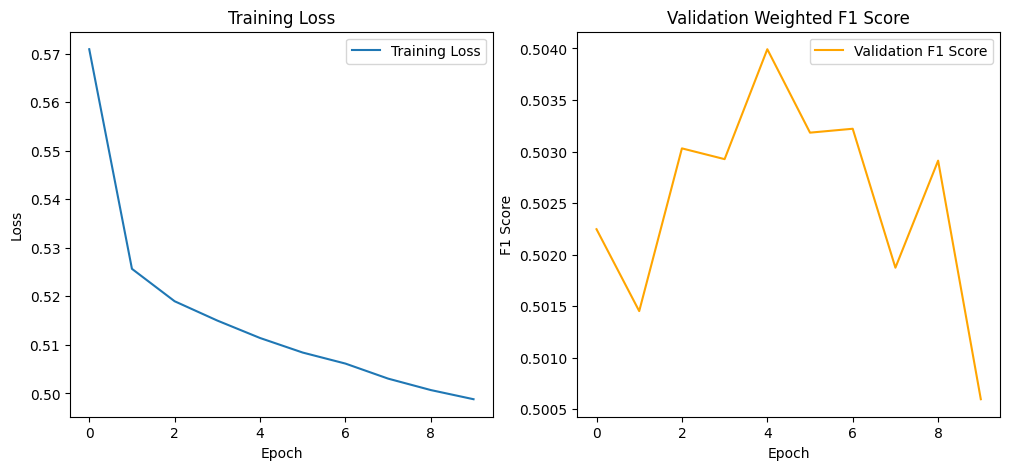

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Генерация случайных данных для примера
# X_train, y_train = ...
# X_test, y_test = ...

# Пример:
# torch.manual_seed(42)
# X_train = torch.randn(100, 10)
# y_train = torch.randint(0, 4, (100,))
# X_test = torch.randn(20, 10)
# y_test = torch.randint(0, 4, (20,))

# Устройство (GPU если доступно)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Датасеты и их загрузчики
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(np.array(y_train['sex']), dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(np.array(y_test['sex']), dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Определение модели
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out).squeeze()
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 250
num_classes = 1
num_epochs = 10
learning_rate = 0.001

model = SimpleNN(input_size, hidden_size, num_classes).to(device)

# Определение критерия и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_f1_scores = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Валидация модели
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_f1_scores.append(val_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

# Построение графиков
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation Weighted F1 Score')
plt.legend()

plt.show()

In [125]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.33      0.01      0.03      2992
           1       0.47      0.65      0.54     25032
           2       0.42      0.37      0.40     26458
           3       0.49      0.39      0.44     17523

    accuracy                           0.46     72005
   macro avg       0.43      0.36      0.35     72005
weighted avg       0.45      0.46      0.44     72005



In [157]:
all_preds[:10], all_labels[:10]

([1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
 [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0])

In [127]:
y_test['preds'] = all_preds

In [129]:
y_test = merged_data.groupby('viewer_uid').agg(
    count=('viewer_uid', 'count')
).reset_index().merge(y_test, on='viewer_uid', how='inner')

In [139]:
cnt = 30
print(classification_report(y_test[y_test['count'] > cnt]['age_class'], y_test[y_test['count'] > cnt]['preds']))

              precision    recall  f1-score   support

           0       0.27      0.04      0.08       181
           1       0.49      0.74      0.59      2083
           2       0.48      0.41      0.44      2161
           3       0.53      0.25      0.34      1072

    accuracy                           0.49      5497
   macro avg       0.44      0.36      0.36      5497
weighted avg       0.49      0.49      0.47      5497



In [140]:
y_test[(np.abs(y_test.age_class - y_test.preds) > 2) & (y_test.age_class == 0)]

,viewer_uid,count,sex,age_class,age,preds
900,10003567,1,1,0,19,3
2210,10009593,1,0,0,20,3
3533,10013650,1,1,0,19,3
3649,10014037,1,1,0,16,3
5085,10018732,7,1,0,12,3
...,...,...,...,...,...,...
71759,11124148,2,1,0,17,3
71774,11125068,5,0,0,11,3
71834,11129218,2,0,0,12,3
71850,11130842,1,0,0,13,3


In [102]:
uid = 10385303
print(targets[targets.viewer_uid == uid]['age_class'].iloc[0])
print()
for idx, text in enumerate(merged_data[merged_data.viewer_uid == uid]['text']):
    print(idx, text)

0

0 РОЛЬ / КЛИНОК Категория: Развлечения
1 ЧТО БУДЕТ ЕСЛИ СЪЕСТЬ ЭТОГО КАЛЬМАРА? Категория: Развлечения
2 Открываю ПВЗ в 2024 году Категория: Бизнес и предпринимательство


In [92]:
cnt = 0
uids = set()
for idx, (text, viewer_uid) in tqdm(merged_data[['text', 'viewer_uid']].iterrows(), total=merged_data.shape[0]):
    if 'minecraft' in text.lower():
        uids.add(viewer_uid)
        cnt += 1
print(cnt, cnt / video.shape[0])

100%|██████████| 1759616/1759616 [00:57<00:00, 30855.96it/s]


2458 0.005105092631054249


In [108]:
cnt = 0
for text in video['text']:
    if 'экстрасенс' in text.lower():
        cnt += 1
print(cnt, cnt / video.shape[0])

1117 0.0023199302151698927


In [94]:
list(uids)[:10]

[10518531,
 10436626,
 10469400,
 10633243,
 10649631,
 10780738,
 10739799,
 10518616,
 10649688,
 10518626]

In [77]:
sparse_row = targets.loc[49846]['embed_tf_idf']
nonzero_indices = sparse_row.nonzero()[1]
tfidf_values = sparse_row.data
terms = tfidf_vectorizer.get_feature_names_out()

# Печатаем термы и их TF-IDF значения
for idx, value in zip(nonzero_indices, tfidf_values):
    print(f"Терм: {terms[idx]}, TF-IDF значение: {value}")

Терм: белый, TF-IDF значение: 0.09261912084335988
Терм: 2005, TF-IDF значение: 0.1001949367769846
Терм: фильм, TF-IDF значение: 0.11157114462892227
Терм: 16, TF-IDF значение: 0.1798152647957852
Терм: 14, TF-IDF значение: 0.20259671767428478
Терм: 12, TF-IDF значение: 0.19723863755171728
Терм: 10, TF-IDF значение: 0.17774696090699488
Терм: луна, TF-IDF значение: 1.9578617596863284
Терм: отель, TF-IDF значение: 1.8830034555237283
Терм: 11, TF-IDF значение: 0.1956690035190261
Терм: 13, TF-IDF значение: 0.19742830630496008
Терм: 15, TF-IDF значение: 0.20091619090545945
Терм: солнце, TF-IDF значение: 2.6472539995378237


In [76]:
nonzero_indices

array([155,  15, 820,   8,   6,   4,   0, 420, 541,   3,   5,   7, 731],
      dtype=int32)

In [53]:
from catboost import CatBoostRegressor


# CatBoost для предсказания возрастной категории
catboost_age = CatBoostRegressor(iterations=1500, verbose=150, depth=3)
catboost_age.fit(X_train, y_train['age'], eval_set=(X_val, y_val['age']))
y_pred_age = catboost_age.predict(X_test)
y_pred_age[(y_pred_age <= 20)] = 0
y_pred_age[(20 < y_pred_age) & (y_pred_age <= 30)] = 1
y_pred_age[(30 < y_pred_age) & (y_pred_age <= 40)] = 2
y_pred_age[(40 < y_pred_age)] = 3

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

Learning rate set to 0.082934
0:	learn: 9.0067197	test: 8.9377359	best: 8.9377359 (0)	total: 10.6ms	remaining: 15.9s
150:	learn: 8.3829353	test: 8.3782496	best: 8.3782496 (150)	total: 1.5s	remaining: 13.4s
300:	learn: 8.2593318	test: 8.2927831	best: 8.2927831 (300)	total: 2.75s	remaining: 11s
450:	learn: 8.1840396	test: 8.2487730	best: 8.2487730 (450)	total: 4.19s	remaining: 9.74s
600:	learn: 8.1275031	test: 8.2229122	best: 8.2229122 (600)	total: 5.6s	remaining: 8.38s
750:	learn: 8.0806284	test: 8.2033142	best: 8.2033142 (750)	total: 6.78s	remaining: 6.76s
900:	learn: 8.0403966	test: 8.1913850	best: 8.1913850 (900)	total: 8.23s	remaining: 5.47s
1050:	learn: 8.0031721	test: 8.1795806	best: 8.1795806 (1050)	total: 9.66s	remaining: 4.13s
1200:	learn: 7.9685141	test: 8.1697647	best: 8.1697647 (1200)	total: 10.9s	remaining: 2.71s
1350:	learn: 7.9359805	test: 8.1609774	best: 8.1608994 (1349)	total: 12.2s	remaining: 1.35s
1499:	learn: 7.9068165	test: 8.1540261	best: 8.1540261 (1499)	total: 13

/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif